# Final Project: How much is your vote worth?
## Author: Eric Bolton
## Date: 01/02/2019
## [Github Repository](https://github.com/edbltn/voter-power)

Many reasons exist to exercise one's right to vote. Beyond simply fulfilling one's civic duty, voting constitutes a way to make one's voice heard, to feel part of something bigger, and to participate in the great democratic experiment. One might want to vote simply because increased turnout [affects policy outcomes](http://www.nyu.edu/gsas/dept/politics/seminars/hajnal_s06.pdf).

Yet, every election cycle in America, tens of millions of eligible voters stay at home. It's easy to see why: in elections where hundreds of thousands vote - sometimes millions - the perception may be that one's voice is likely to be lost in the cacophony of the crowd, providing little motivation to head to the polls. One might argue that one's vote only truly "counts" if their vote is the one to push their candidate of choice over the brink, an event that many see as far too unlikely to warrant a visit to the voting booth.

But this perception may be misguided. Consider this: if each vote has only a one in ten million chance of changing the outcome of an election, but that election affects billions of dollars in spending at a national scale, then each vote is effectively "worth" hundreds of dollars. In this light, voting is a rational decision per se, if only as an act of charity. This is the argument made by renowned statistician [Andrew Gelman](https://80000hours.org/2016/11/why-the-hour-you-spend-voting-is-the-most-socially-impactful-of-all/).

So, using this reasoning, how much is one's vote truly worth? This project seeks to answer that in the context of the 2018 Midterm Elections for the House and Senate.

# Simulating Elections

In order to come up with an answer, we first need to discover the likelihood that one's vote would have changed the outcome of individual races. Leading up to Election Day, this perceived likelihood depended on two key factors: what the polls were saying about each race (closer races, and more uncertain races have higher odds of being decided by one vote) and what kind of turnout is expected (races with fewer voters have higher odds of being decided by one vote). To this end, I designed a `Country` object that would read and organize the relevant data\* into `State` objects, which in turn were associated with `Race` objects.

\*Available in the [Github repository](https://github.com/edbltn/voter-power)

In [2]:
import elections

# Create national election predictor
country = elections.Country('../data')

First I looked at the polls for each race leading up to Election Day. I only considered polls that were taken during October or November\*. Here I assumed that races with no such polls available were essentially uncontested - an assumption that held true in a vast majority of cases, but that definitely weakens the analysis. Follow up work should seek to use voting history for counties as a predictor for races where polling data was lacking.

My next assumption was that the number of polling respondents favoring a given candidate would follow a Binomial distribution $B(n, p)$ where $n$ is the number of polling samples and $p$ is the probability of any voter casting a vote for the given candidate. I approximated this distribution as a Normal distribution with mean $n\hat{p}$ and variance $n\hat{p}(1-\hat{p})$ where $\hat{p}$ was the observed proportion of polling respondents favoring the given candidate.

I used a truncated distribution (`scipy.stats.truncnorm`) to ensure that it would only include values between 0 and $n$. Dividing by $n$, this yielded a distribution for $p$, the probability that any voter would pick the given candidate, based on polling data:

$
p\sim N_0^{1}\left(\hat{p},\sqrt{\frac{\hat{p}(1-\hat{p})}{n}}\right)
$

Where $N_0^1$ designates a truncated normal distribution between 0 and 1. We'll use $N_0^1$ as a shorthand for the above expression going forward.

Let $V$ be the number of votes cast for the given candidate. Now, for a given turnout $t$, the probability that exactly $k = \left\lceil\frac{t}{2}\right\rceil$ voters would pick the given candidate (hence - all votes are "decisive," assuming a two-candidate election), would be:

$
P[V = k]_{p\sim N_0^1} = \left({t \atop k}\right)p^k(1-p)^{t-k}
$

Thus the expected tipping point probability can be computed by integrating over $N_0^1$.

$
\mathbb{E}[P[V=k]]_{p\sim N_0^1} = \int_{0}^1 \left({t \atop k}\right)p^k(1-p)^{t-k}N_0^1(p)dp
$

This can be computed using `scipy.stats.rv_continuous.expect`.

Now, the only missing factor is the expected turnout. Here, I cheated a little and used the actual turnout on Election Day; future work should use projected turnout based on early vote counts and voting history.

\*Polls were obtained from [Real Clear Politics](https://www.realclearpolitics.com/elections/2018/)

In [6]:
district_probabilities = {}
for state in country.states:
    for district in state.districts.values():
        p = district.tipping_point_probability()
        district_probabilities[district.code] = p

Typically, only one Senate seat is contested per state. But the exits of Al Franken (D-MN) and Thad Cochran (R-MS) from the Senate required special elections in Minnesota and Mississippi. This meant that these states each had two Senate elections in 2018. For simplicity's sake, I'm picking the larger of the two probabilities in these cases.

(*Note that the seats are examined in alphabetical order of their codes - i.e. 'MS' will be seen before 'MS2'*)

In [7]:
senate_seat_probabilities = {}
for state in country.states:
    for seat in state.senate_seats.values():
        p = seat.tipping_point_probability()
        if not seat.code.endswith('2'):
            senate_seat_probabilities[state.name] = p
        else:
            senate_seat_probabilities[state.name] = max(p, senate_seat_probabilities[state.name])

# Simulating Chamber Votes

Now that we know the likelihood of one's vote changing the outcome for each individual race, we want to compute the likelihood of each individual race changing the outcome of key House and Senate votes. To predict the outcome of votes, I used partisanship scores available on [VoteView](https://voteview.com), which tracks the partisanship of each senator and representative based on their voting history. For candidates whose partisanship scores weren't available, I simply used the average score of elected officials from their party in their state.

I created a `ChamberVote` object that looks at how Senators or Representatives actually voted on a past issue\* in order to predict, using logistic regression, how a new class of elected officials would vote. In this example, I use the Senate vote to repeal Obamacare, which narrowly failed on July 28, 2017.

\*This data is also available via [VoteView](https://voteview.com).

In [10]:
from votes import ChamberVote

vote = ChamberVote('../data/votes/obamacare_senate.csv', 
                   country.official_scorer)

Now, all that remains to be done is to simulate different elections and use that to estimate how often the Obamacare vote would come down to just one vote in either chamber. In the past, polling has been known to exhibit a national bias of up to 2\% toward one party or the other, so I am including a bias factor for each election cycle.

In [11]:
import numpy as np
import progressbar

sims = 10000
senate_power = 0
house_power = 0
p = progressbar.ProgressBar(term_width = 80)

for n in p(range(sims)):
    
    election_bias = np.random.normal(0, 0.02)
    
    # Include Mike Pence's tie-breaking vote
    mike_pence_score = np.matrix([0.655, 0.088])
    senate_scores = country.simulate_senate(election_bias)
    senate_scores = np.concatenate((senate_scores, mike_pence_score))
    senate_diff = vote.get_result(senate_scores)
    
    house_scores = country.simulate_house(election_bias)
    house_diff = vote.get_result(house_scores)
    
    if abs(senate_diff) == 1:
        senate_power += 1
    if abs(house_diff == 1):
        house_power += 1

house_power /= sims
senate_power /= sims

100% |#########################################################################|


Finally, we can combine the probability that a voter would be decisive in their race, and the probability that their candidate of choice would be decisive in their chamber, by multiplying them (assuming they represent independent events).

$
P[\textrm{"Voter is decisive"} \cap \textrm{"Elected Official is decisive"}] = P[\textrm{"Voter is decisive"}] \cdot P[\textrm{"Elected Official is decisive"}]
$

We can then multiply this result by the cost of Obamacare (\$133 billion) estimated by the Congressional Budget Office. This will tell us how much each vote was worth in the 2018 election when it came to the issue of healthcare.

In [22]:
from collections import defaultdict
from heapq import nlargest
from operator import itemgetter
import pandas as pd

# Obamacare cost estimate
cost = 1.33e9 

senate_seats = defaultdict(lambda: [])
senate_seat_values = {}
for senate_seat, p in senate_seat_probabilities.items():
    senate_seats['state'].append(senate_seat)
    senate_seats['decisive_voter_probability'].append(p)
    
    value = p * cost * senate_power
    senate_seat_values[senate_seat] = value
    value_string = f'${round(value, 2):.2f}'
    senate_seats['value_of_vote'].append(value_string)

districts = defaultdict(lambda: [])
district_values = {}
for district, p in district_probabilities.items():
    districts['district'].append(district)
    districts['decisive_voter_probability'].append(p)
    
    value = p * cost * house_power
    district_values[district] = value
    value_string = f'${round(value, 2):.2f}'
    districts['value_of_vote'].append(value_string)
    
senate_seats_df = pd.DataFrame.from_dict(senate_seats)
districts_df = pd.DataFrame.from_dict(districts)

display(districts_df.nlargest(10, 'decisive_voter_probability'))
display(senate_seats_df.nlargest(10, 'decisive_voter_probability'))

,district,decisive_voter_probability,value_of_vote
180,ME2,0.000122,$3142.25
97,FL26,0.000113,$2902.19
266,NY22,0.000108,$2769.87
53,CA39,0.000107,$2750.06
50,CA10,0.000107,$2738.35
293,NC9,0.000106,$2713.30
45,CA3,0.000105,$2692.03
248,NJ3,0.000099,$2553.57
205,MI8,0.000091,$2332.45
405,VA7,0.000087,$2242.28


,state,decisive_voter_probability,value_of_vote
2,Arizona,2.956321e-05,$7769.45
27,Nevada,2.387209e-05,$6273.78
13,Indiana,8.375660e-06,$2201.19
24,Missouri,3.792585e-07,$99.67
25,Montana,4.958546e-18,$0.00
47,West Virginia,4.273533e-18,$0.00
8,Florida,2.734816e-18,$0.00
23,Mississippi,1.568430e-20,$0.00
37,Pennsylvania,1.535593e-22,$0.00
41,Tennessee,4.930823e-24,$0.00


Thus, voters in many states performed a substantial act of charity simply by making their way to their local polling station. In the closely followed and hotly contested race between Kyrsten Sinema and Martha McSally, each vote was worth almost \$8000, based on just one of many Senate votes. The races in Nevada and Indiana were worth thousands of dollars per vote as well.

When these states voted on November 8th, 2018, millions of lives, and billions of dollars hung in the balance. Yet the states only had middling turnout, at 49.10\%, 47.50\%, and 46.90\% each, compared to 50.10\% nationally.

Finally, let's see how these results look on a map:

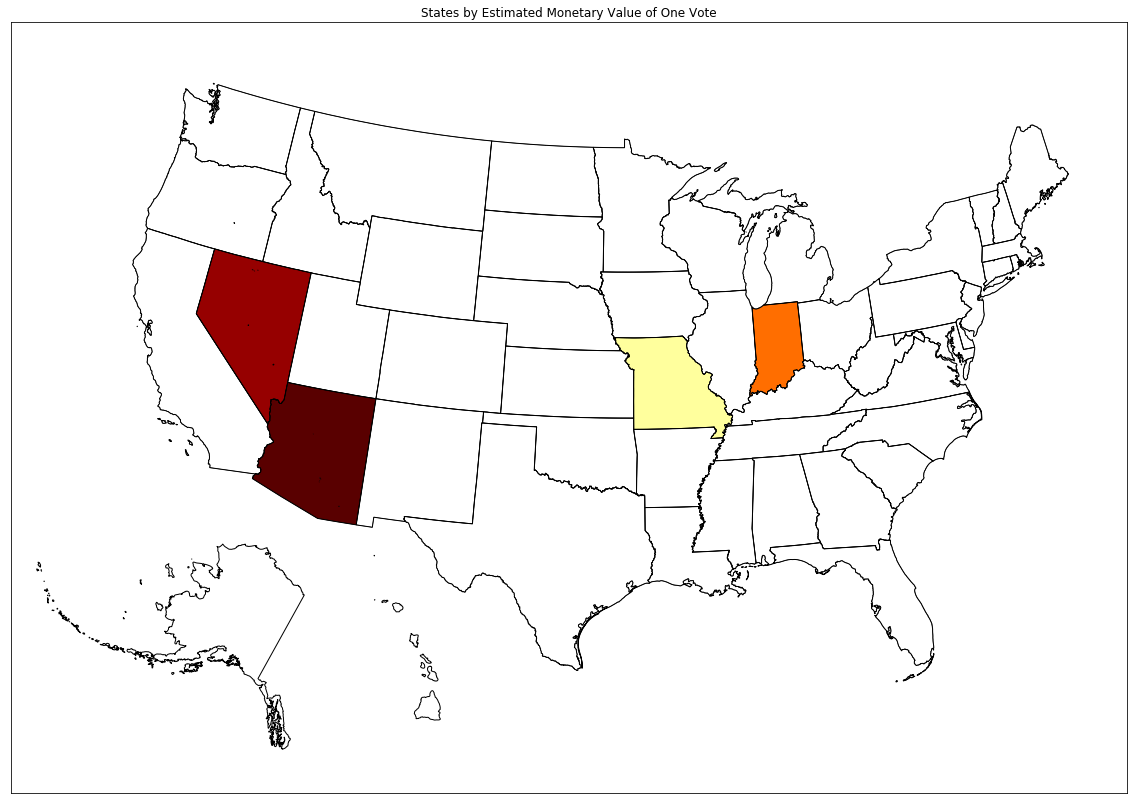

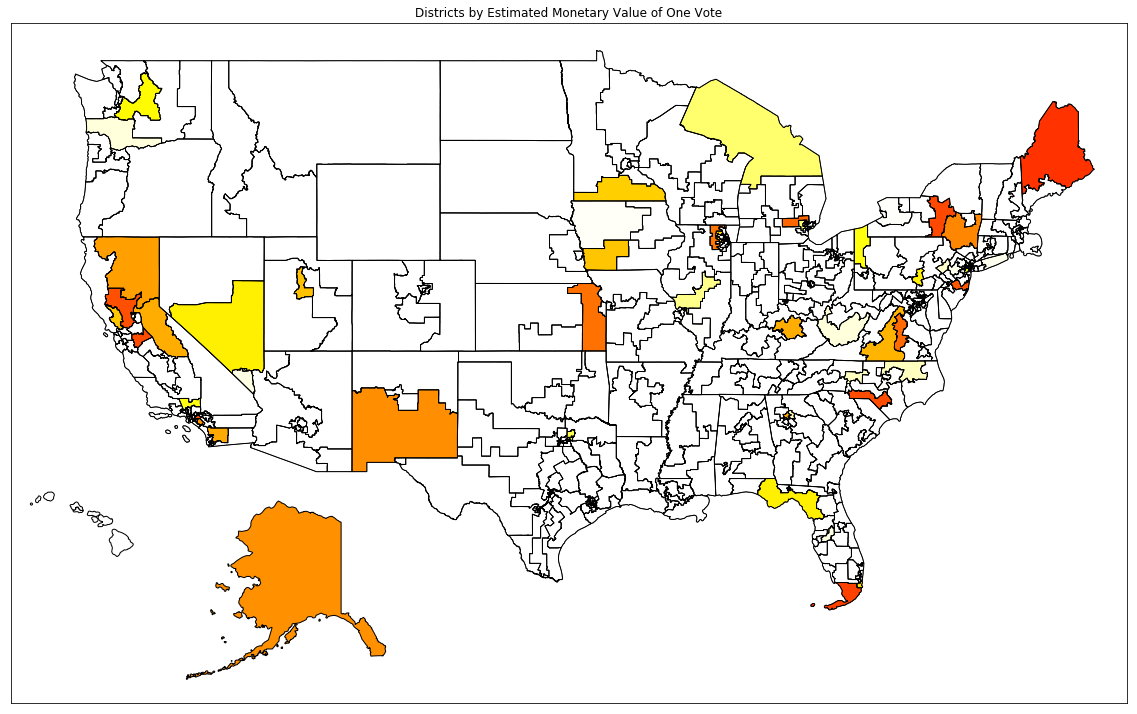

In [28]:
from plot_us_map import plot_districts, plot_states

plot_states(senate_seat_values, 0, 10000)
plot_districts(district_values, 0, 10000)

Shapefiles can be found [here](https://www.census.gov/geo/maps-data/data/cbf/cbf_state.html) for the states (simply select 'Census 2000' and then select 'United States') and [here](https://koordinates.com/layer/96077-us-116th-congressional-districts/) for the districts.

It's immediately striking that votes in some states had a negligible value, while votes in others were worth thousands of dollars each. Perhaps, in a better system, each vote would weigh equally. Analyses such as these show where the difference needs to be made, perhaps by working to reduce gerrymandering, or changing voting rules to make individual votes more impactful. One example might be the effort [spearheaded by Maine's 2nd](https://thehill.com/opinion/campaign/418058-maines-2nd-district-outcome-proves-value-of-ranked-choice-voting) in this election cycle to switch to a ranked choice voting system (votes in that tightly contested race, by the way, were worth \$3,000 apiece). But beyond that, in the states and districts where voting mattered most, it is my hope that analyses such as these might cause those who stayed at home to reconsider their decision in future elections.